# Brain tumor classification project

This notebook covers the whole steps of building a simple brain tumor detection model. The technique used in this notebook is Transfer Learning where we'll be training a pretrained Resnet50 model to be able to classify brain tumor based on images given.

**Dataset** : https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
!nvidia-smi

Tue Oct  8 03:18:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Load in dataset

Let's load in the dataset for the model

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "brain_tumor_dataset"
image_path.mkdir(parents=True, exist_ok=True)

if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "brain_tumor_dataset.zip", "wb") as f:
  request = requests.get("https://github.com/itsqal/Brain-tumor-classification-model/raw/refs/heads/main/Brain%20tumor%20dataset.zip")
  print("Downloading brain tumor dataset...")
  f.write(request.content)

# Unzip the data
with zipfile.ZipFile(data_path / "brain_tumor_dataset.zip", 'r') as zip_ref:
  print("Unzipping brain tumor dataset...")
  zip_ref.extractall(image_path)

data/brain_tumor_dataset directory already exists... skipping download
Unzipping brain tumor dataset...


## 2. Data exploration

In [4]:
import os

def walk_through_dir(dir_path):
  """Walks to dit_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [6]:
walk_through_dir(image_path)

There are 3 directories and 0 images in 'data/brain_tumor_dataset'
There are 0 directories and 98 images in 'data/brain_tumor_dataset/no'
There are 0 directories and 155 images in 'data/brain_tumor_dataset/yes'
There are 2 directories and 0 images in 'data/brain_tumor_dataset/brain_tumor_dataset'
There are 0 directories and 98 images in 'data/brain_tumor_dataset/brain_tumor_dataset/no'
There are 0 directories and 155 images in 'data/brain_tumor_dataset/brain_tumor_dataset/yes'


Let's check and visualize one of the images.

Random image path : data/brain_tumor_dataset/yes/Y37.jpg
Image height : 360
Image width : 319
Image size : (319, 360)


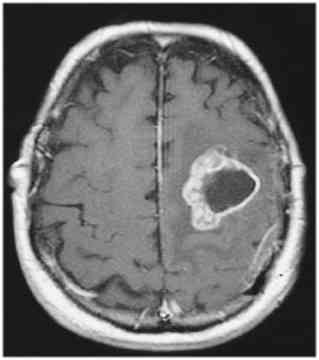

In [10]:
import random
from PIL import Image

img_paths = list(image_path.glob("*/*.jpg"))
img_path = random.choice(img_paths)
img = Image.open(img_path)

print(f"Random image path : {img_path}")
print(f'Image height : {img.height}')
print(f"Image width : {img.width}")
print(f"Image size : {img.size}")
img

## 3. Data preparation

Let's prepare our data by splitting it into train and test sets. After that we'll create dataset and dataloader for our transfer learning.

In [42]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(image_path / "brain_tumor_dataset", transform=train_transforms)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Overwrite the transform
test_dataset.dataset.transform = test_transforms

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Classes: ", dataset.classes)

Classes:  ['no', 'yes']


In [43]:
print(f"Train data length : {len(train_dataset)}")
print(f"Test data length : {len(test_dataset)}")

Train data length : 202
Test data length : 51


In [44]:
print(len(test_loader))

4


Visualizing the data after transformation

In [45]:
data_batch, label = next(iter(train_loader))
print(f"Shape of data : {data_batch.shape}")
print(f"Shape of label : {label.shape}")

Shape of data : torch.Size([16, 3, 224, 224])
Shape of label : torch.Size([16])


(-0.5, 223.5, 223.5, -0.5)

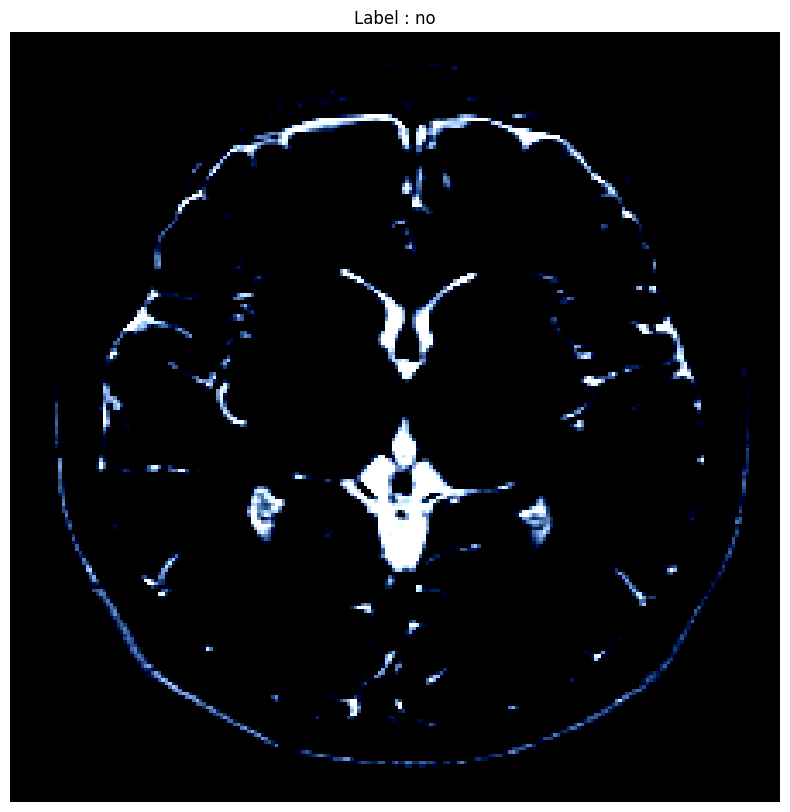

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(data_batch[1].permute(1, 2, 0))
plt.title(f"Label : {dataset.classes[label[1]]}")
plt.axis("off")

## 4. Training the model

Now that the train and test dataloaders are ready, let's train our pretrained model.

In [47]:
# Create accuracy function
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm.auto import tqdm

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [49]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 5

for epoch in tqdm(range(epochs)):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}%")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.4472 | Train Acc: 77.1154%
Epoch: 2 | Train Loss: 0.1099 | Train Acc: 94.2308%
Epoch: 3 | Train Loss: 0.0388 | Train Acc: 99.0385%
Epoch: 4 | Train Loss: 0.1005 | Train Acc: 96.5385%
Epoch: 5 | Train Loss: 0.0564 | Train Acc: 98.5577%


It seems that our model is doing pretty well. Let's test it out on the testing data.

In [64]:
# Creating testing loops

model.eval()

test_loss, test_acc = 0, 0

with torch.inference_mode():
  for batch, (X, y) in tqdm(enumerate(test_loader)):
    X, y = X.to(device), y.to(device)
    test_pred = model(X)

    loss = loss_fn(test_pred, y)
    test_loss += loss.item()
    test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}%")

0it [00:00, ?it/s]

Test Loss: 0.1704 | Test Acc: 93.7500%


## 5. Evaluating our model

After training and testing our model, we're gonna evaluate the model using f1-score and build a confusion matrix

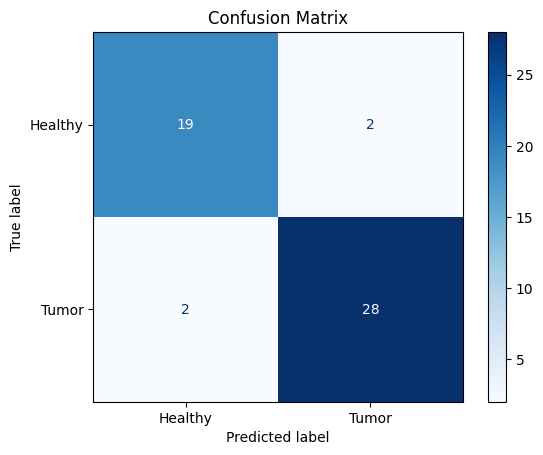

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

def evaluate_model(model, dataloader):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

    return np.array(true_labels), np.array(predictions)

# Call eval function to get true labels and predictions
true_labels, predictions = evaluate_model(model, test_loader)

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Tumor"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [53]:
# Calculate F1 Score
f1 = f1_score(true_labels, predictions, average='weighted')
print(f'F1 Score: {f1:.4f}')

F1 Score: 0.9216


From the evaluation, we can see that our model did pretty well. It correctly classified most of the healthy and tumor brains.

## 6. Save the model

In [54]:
# Saving our model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = 'brain_tumor_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)# Saving our model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = 'pytorch_workflow_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to models/brain_tumor_model.pth


## 7. Uploading the model to Huggingface

In [56]:
!pip install huggingface_hub

In [57]:
from huggingface_hub import login

login()

In [58]:
from huggingface_hub import create_repo

repo_name = "brain_tumor_classification"
create_repo(repo_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


RepoUrl('https://huggingface.co/anakingfl/brain_tumor_classification', endpoint='https://huggingface.co', repo_type='model', repo_id='anakingfl/brain_tumor_classification')

In [59]:
from huggingface_hub import HfApi

# Initialize the API
api = HfApi()

# Push the model to the Hugging Face repository
api.upload_file(
    path_or_fileobj='models/brain_tumor_model.pth',
    path_in_repo="brain_tumor_model.pth",
    repo_id="anakingfl/brain_tumor_classification",
    repo_type="model"
)

brain_tumor_model.pth:   0%|          | 0.00/94.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/anakingfl/brain_tumor_classification/commit/5e5d282ef56fccb9c30f0b14364b8e2732392e37', commit_message='Upload brain_tumor_model.pth with huggingface_hub', commit_description='', oid='5e5d282ef56fccb9c30f0b14364b8e2732392e37', pr_url=None, pr_revision=None, pr_num=None)

## 8. Testing with gradio

In [60]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.6 MB/s eta 0:00:00


In [61]:
transform = transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [69]:
from PIL import Image
import gradio as gr

def predict(image):
  try:
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    # Perform inference
    with torch.no_grad():
        preds = model(image)
        predicted_class = torch.argmax(preds, dim=1).item()

    # Class labels (you can adjust these based on your dataset)
    class_labels = ['Healthy', 'Tumor']

    return f"Classfication result : {class_labels[predicted_class]}"
  except Exception as e:
    return f"Error: {str(e)}"

In [70]:
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Brain tumor classification model",
)

interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2bdefc9d20d3e911fc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
